# Persiapan Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.layers import LSTM, Dense, Input, GlobalAveragePooling1D, TimeDistributed
from tensorflow.keras.models import Model

# Persiapan Dataset

In [2]:
csv_url = 'https://drive.google.com/uc?export=download&id=1hpsqSpfjdqIZWqwd259klQSeaNSe5Trr'

df = pd.read_csv(csv_url)

df.head()

,Date,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
0,2017-09-21 09:00:00.000,3860.00,74434.891166,49.192454,-48.279697,88.054720,2.495591
1,2017-09-21 10:00:00.000,3871.48,44687.318944,49.233202,-47.780476,87.996283,2.616710
2,2017-09-21 11:00:00.000,3864.95,80546.171672,49.210685,-47.308061,87.897128,2.532239
3,2017-09-21 12:00:00.000,3858.08,90331.531390,49.186948,-46.863233,87.720856,2.447245
4,2017-09-21 13:00:00.000,3856.67,103405.818040,49.182064,-46.425379,87.578086,2.424654


In [3]:
df['Date'] = pd.to_datetime(df['Date'], format='mixed')
df = df.sort_values('Date').set_index('Date')
df

,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO
Date,,,,,,
2017-09-21 09:00:00,3860.00,7.443489e+04,49.192454,-48.279697,88.054720,2.495591
2017-09-21 10:00:00,3871.48,4.468732e+04,49.233202,-47.780476,87.996283,2.616710
2017-09-21 11:00:00,3864.95,8.054617e+04,49.210685,-47.308061,87.897128,2.532239
2017-09-21 12:00:00,3858.08,9.033153e+04,49.186948,-46.863233,87.720856,2.447245
2017-09-21 13:00:00,3856.67,1.034058e+05,49.182064,-46.425379,87.578086,2.424654
...,...,...,...,...,...,...
2023-10-19 19:00:00,28750.75,2.984059e+07,53.630054,109.926882,129.065981,7.459700
2023-10-19 20:00:00,28715.38,4.997623e+07,53.531282,111.721905,129.268969,7.118597
2023-10-19 21:00:00,28604.09,3.205666e+07,53.221944,113.055031,129.287930,6.210037


# Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53150 entries, 2017-09-21 09:00:00 to 2023-10-19 23:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        53150 non-null  float64
 1   Volume USDT  53150 non-null  float64
 2   RSI          53150 non-null  float64
 3   MACD_Hist    53150 non-null  float64
 4   ATR          53150 non-null  float64
 5   KAMAO        53150 non-null  float64
dtypes: float64(6)
memory usage: 2.8 MB


## Feature Engineering

In [5]:
# ukuran window untuk Rolling Statistic
short_window = 24
long_window = 48

df['rolling_mean'] = df['Close'].rolling(window=short_window).mean()
df['rolling_std'] = df['Close'].rolling(window=long_window).std()

# isi nilai NaN dengan 0
df.fillna(0, inplace=True)

df

,Close,Volume USDT,RSI,MACD_Hist,ATR,KAMAO,rolling_mean,rolling_std
Date,,,,,,,,
2017-09-21 09:00:00,3860.00,7.443489e+04,49.192454,-48.279697,88.054720,2.495591,0.000000,0.000000
2017-09-21 10:00:00,3871.48,4.468732e+04,49.233202,-47.780476,87.996283,2.616710,0.000000,0.000000
2017-09-21 11:00:00,3864.95,8.054617e+04,49.210685,-47.308061,87.897128,2.532239,0.000000,0.000000
2017-09-21 12:00:00,3858.08,9.033153e+04,49.186948,-46.863233,87.720856,2.447245,0.000000,0.000000
2017-09-21 13:00:00,3856.67,1.034058e+05,49.182064,-46.425379,87.578086,2.424654,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2023-10-19 19:00:00,28750.75,2.984059e+07,53.630054,109.926882,129.065981,7.459700,28412.270000,151.483898
2023-10-19 20:00:00,28715.38,4.997623e+07,53.531282,111.721905,129.268969,7.118597,28431.843333,156.854031
2023-10-19 21:00:00,28604.09,3.205666e+07,53.221944,113.055031,129.287930,6.210037,28446.500833,159.006638


In [6]:
selected_features = ['Close', 'Volume USDT', 'RSI', 'MACD_Hist', 'ATR', 'KAMAO', 'rolling_mean', 'rolling_std']
df_features = df[selected_features]

## Correlation Heatmap


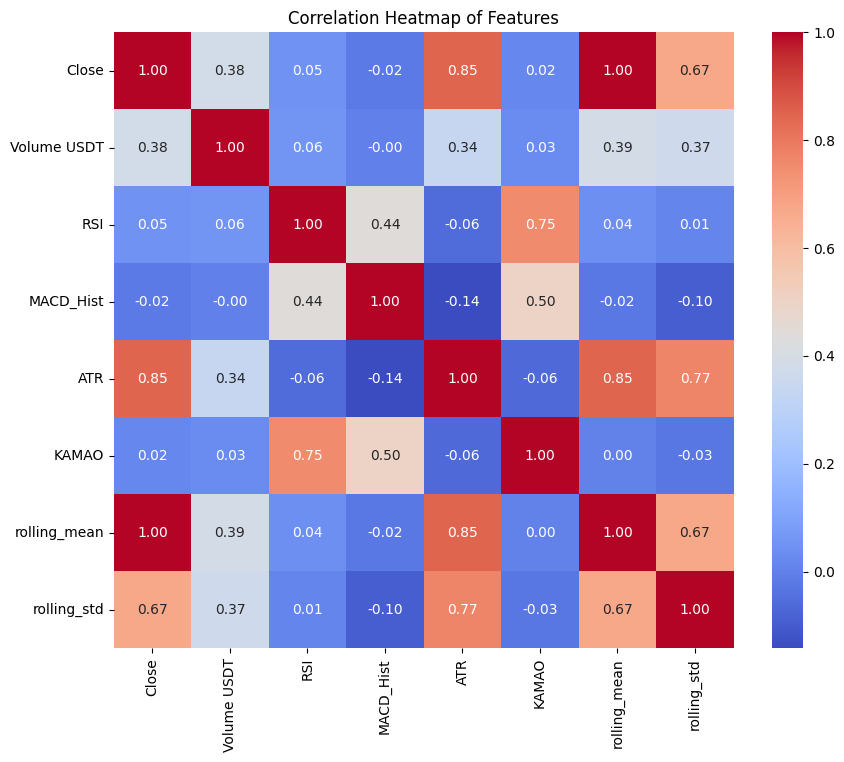

In [7]:
correlation_matrix = df_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

## Dekomposisi Data


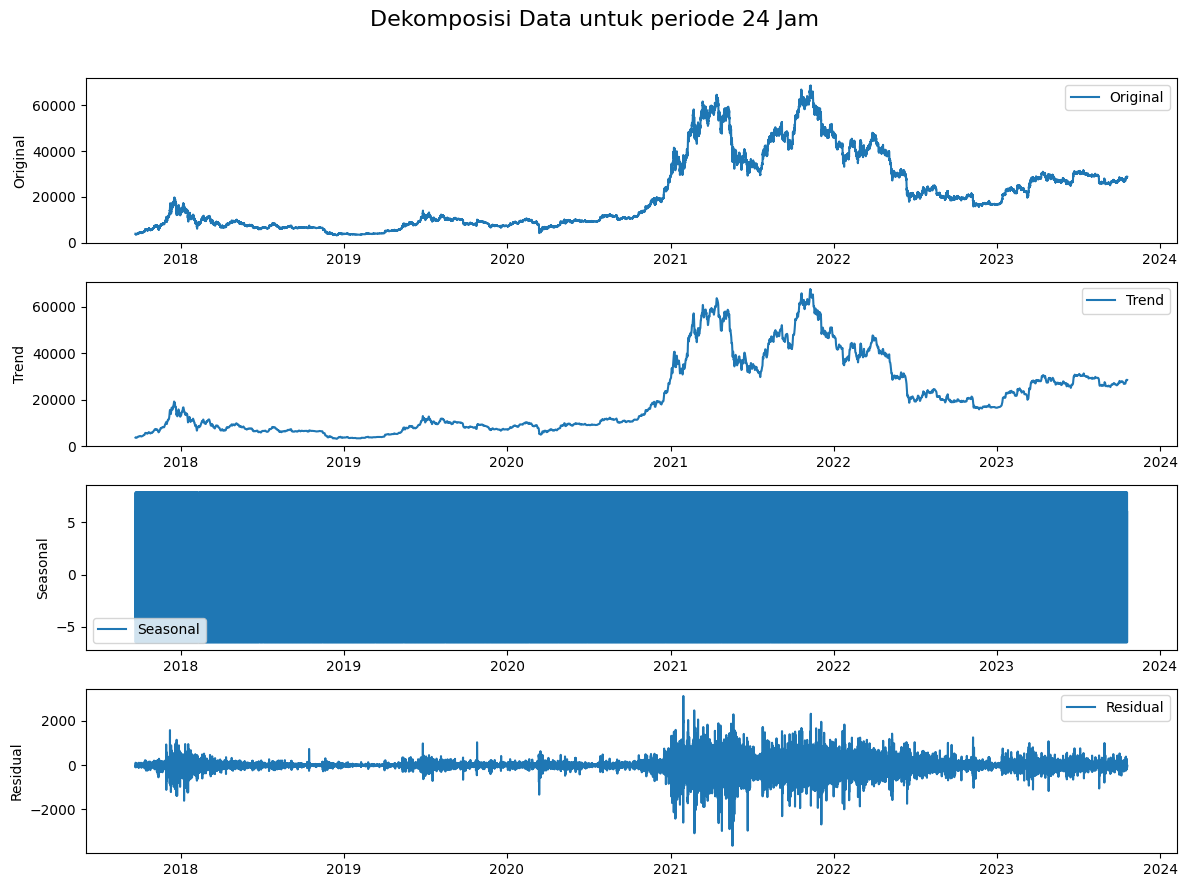

In [8]:
decomposition = seasonal_decompose(df_features['Close'], model='additive', period=24)

components = {
    'Original': df_features['Close'],
    'Trend': decomposition.trend,
    'Seasonal': decomposition.seasonal,
    'Residual': decomposition.resid
}

plt.figure(figsize=(12, 9))
plt.suptitle('Dekomposisi Data untuk periode 24 Jam', fontsize=16)

for i, (title, series) in enumerate(components.items(), start=1):
  plt.subplot(4,1,i)
  plt.plot(df_features.index, series, label=title)
  plt.legend(loc='best')
  plt.ylabel(title)

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

## ACF and PACF


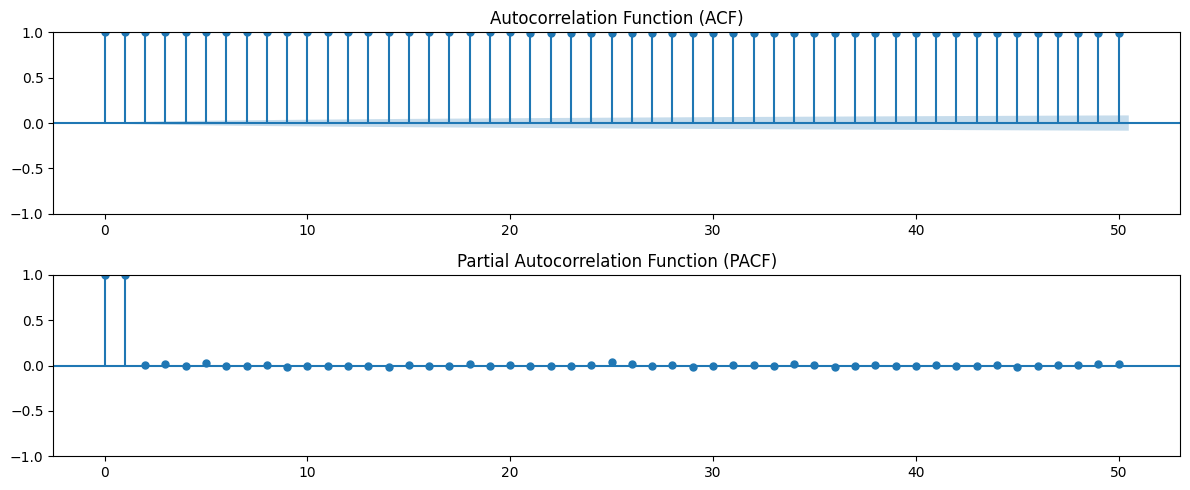

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(211)
plot_acf(df_features['Close'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(212)
plot_pacf(df_features['Close'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Data Splitting


In [10]:
total_size = len(df_features)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

df_train = df_features.iloc[:train_size]
df_val = df_features.iloc[train_size:train_size + val_size]
df_test = df_features.iloc[train_size + val_size:]

## Normalisasi Data


In [11]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(df_train)
val_scaled = scaler.transform(df_val)
test_scaled = scaler.transform(df_test)

## Data Pipeline


In [12]:
# Definisi panjang input dan output
INPUT_LENGTH = 48
OUTPUT_LENGTH = 24
TOTAL_LENGTH = INPUT_LENGTH + OUTPUT_LENGTH
BATCH_SIZE = 32

### Baseline LSTM Model

In [13]:
def lstm_create_window(data, input_length, output_length, total_length):
  X, y = [], []
  for i in range(len(data) - total_length + 1):
    X.append(data[i : i + input_length, :])
    y.append(data[i + input_length : i + total_length, 0])
  return np.array(X), np.array(y)

def lstm_tf_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
  dataset = tf.data.Dataset.from_tensor_slices((X, y))
  if shuffle:
    dataset = dataset.shuffle(1000)
  return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# buat window untuk setiap set data
X_train, y_train = lstm_create_window(train_scaled, INPUT_LENGTH, OUTPUT_LENGTH, TOTAL_LENGTH)
X_val, y_val = lstm_create_window(val_scaled, INPUT_LENGTH, OUTPUT_LENGTH, TOTAL_LENGTH)
X_test, y_test = lstm_create_window(test_scaled, INPUT_LENGTH, OUTPUT_LENGTH, TOTAL_LENGTH)

# buat data pipeline
lstm_train_ds = lstm_tf_dataset(X_train, y_train)
lstm_val_ds = lstm_tf_dataset(X_val, y_val, shuffle=False)
lstm_test_ds = lstm_tf_dataset(X_test, y_test, shuffle=False)

### Seq2Seq LSTM Model

In [14]:
def seq2seq_create_window(window, input_length, output_length):
  num_features = window.shape[1]

  # encoder input
  encoder_input = window[:input_length, 0:1]

  # decoder target kolom yang diprediksi 'Close'
  decoder_target = window[input_length:input_length + output_length, 0:1]
  # start token yaitu nilai terakhir dari encoder_input yaitu kolom target
  start_token = encoder_input[-1:, 0:1]

  # gabungkan start token dengan target masa depan (tanpa nilai terakhir)
  decoder_input = tf.concat([start_token, decoder_target[:-1]], axis=0)

  return (encoder_input, decoder_input), decoder_target

def seq2seq_tf_dataset(series, input_length, output_length, batch_size):
  total_length = input_length + output_length

  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(total_length, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(total_length))
  ds = ds.map(lambda w: seq2seq_create_window(w, input_length, output_length))

  return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

seq2seq_train_ds = seq2seq_tf_dataset(train_scaled, INPUT_LENGTH, OUTPUT_LENGTH, BATCH_SIZE)
seq2seq_val_ds = seq2seq_tf_dataset(val_scaled, INPUT_LENGTH, OUTPUT_LENGTH, BATCH_SIZE)
seq2seq_test_ds = seq2seq_tf_dataset(test_scaled, INPUT_LENGTH, OUTPUT_LENGTH, BATCH_SIZE)

# Membangun dan Melatih Model

## Custom Dense Layer

In [15]:
class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        output = tf.matmul(inputs, self.kernel) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (self.units,)

    def get_config(self):
        config = super().get_config()
        config.update({
            "units": self.units,
            "activation": tf.keras.activations.serialize(self.activation)
        })
        return config

## Custom Multi-Head Attention Layer


In [16]:
class CustomMultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.depth = key_dim * num_heads

    def build(self, input_shape):
        input_features = input_shape[-1]

        # Query, Key, Value projection layers
        self.query_dense_inner = tf.keras.layers.Dense(self.depth, name='query_projection')
        self.key_dense_inner = tf.keras.layers.Dense(self.depth, name='key_projection')
        self.value_dense_inner = tf.keras.layers.Dense(self.depth, name='value_projection')

        # Final output projection layer
        self.final_dense_inner = tf.keras.layers.Dense(input_features, name='output_projection')

        super().build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, timesteps, depth)
        # Reshape to (batch_size, timesteps, num_heads, key_dim)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.key_dim))
        # Transpose to (batch_size, num_heads, timesteps, key_dim)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask=None):
        # q, k, v shape: (batch_size, num_heads, timesteps, key_dim)
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        return output, attention_weights

    def call(self, inputs, mask=None):
        # inputs shape: (batch_size, timesteps, features)
        query = inputs
        key = inputs
        value = inputs

        batch_size = tf.shape(query)[0]
        timesteps = tf.shape(query)[1]
        features = tf.shape(query)[2]

        # Reshape for inner Dense layers: (batch_size * timesteps, features)
        reshaped_query = tf.reshape(query, (-1, features))
        reshaped_key = tf.reshape(key, (-1, features))
        reshaped_value = tf.reshape(value, (-1, features))

        # Apply Dense layers
        q_flat = self.query_dense_inner(reshaped_query)  # (batch*timesteps, depth)
        k_flat = self.key_dense_inner(reshaped_key)
        v_flat = self.value_dense_inner(reshaped_value)

        # Reshape back to (batch_size, timesteps, depth) for attention
        q = tf.reshape(q_flat, (batch_size, timesteps, self.depth))
        k = tf.reshape(k_flat, (batch_size, timesteps, self.depth))
        v = tf.reshape(v_flat, (batch_size, timesteps, self.depth))

        # Split heads
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Calculate attention
        scaled_attention, attention_weights = self.scaled_dot_product_attention(
            q, k, v, mask)

        # Concatenate heads
        # Reshape back to (batch_size, timesteps, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, timesteps, self.depth))

        # Reshape for final_dense_inner: (batch_size * timesteps, depth)
        reshaped_concat_attention = tf.reshape(concat_attention, (-1, self.depth))

        # Final output projection
        output_flat = self.final_dense_inner(reshaped_concat_attention)
        output = tf.reshape(output_flat, (batch_size, timesteps, features))

        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "key_dim": self.key_dim
            }
        )
        return config

## Custom Dropout Layer


In [17]:
class CustomDropout(tf.keras.layers.Layer):
    def __init__(self, rate, **kwargs):
        super().__init__(**kwargs)
        self.rate = rate
        if not (0 <= self.rate <= 1):
            raise ValueError("Dropout harus antara 0 and 1.")

    def call(self, inputs, training=None):
        if training:
            # Generate a random mask
            noise_shape = tf.shape(inputs)
            random_tensor = tf.random.uniform(noise_shape, dtype=inputs.dtype)
            # Create a mask where elements are kept with probability (1 - rate)
            keep_mask = random_tensor >= self.rate

            # Apply the mask and scale the output
            output = inputs * tf.cast(keep_mask, inputs.dtype)
            output = output / (1.0 - self.rate)
            return output
        return inputs

    def compute_output_shape(self, input_shape):
        # Dropout does not change the shape of the input tensor
        return input_shape

    def get_config(self):
        config = super().get_config()
        config.update({
            "rate": self.rate
        })
        return config

## Custom Training

In [18]:
class CustomMAELoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_mae_loss"):
        super().__init__(name=name)

    def call(self, y_true, y_pred):
        # Menghitung selisih absolut antara y_true
        return tf.reduce_mean(tf.abs(y_true - y_pred))

In [19]:
class CustomEarlyStopping(tf.keras.callbacks.EarlyStopping):
  def __init__(self, patience=5, min_delta=0.0):
    self.patience = patience
    self.min_delta = min_delta
    self.wait = 0
    self.best_loss = float('inf')
    self.stop_training = False

  def on_epoch_end(self, current_loss):
    if current_loss < self.best_loss - self.min_delta:
      self.best_loss = current_loss
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        self.stop_training = True

In [20]:
loss_object = CustomMAELoss()
optimizer_lstm = tf.keras.optimizers.Adam(learning_rate=0.001)
optimizer_seq2seq = tf.keras.optimizers.Adam(learning_rate=0.001)
early_stopper = CustomEarlyStopping(patience=5, min_delta=0.001)

train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')

### Baseline LSTM Model

In [21]:
@tf.function
def lstm_train_step(inputs, targets, model):
  with tf.GradientTape() as tape:
    predictions = model(inputs, training=True)
    loss = loss_object(targets, predictions)

  tf.debugging.check_numerics(loss, "Loss contains NaN or Inf")

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer_lstm.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss_metric.update_state(loss)

@tf.function
def lstm_val_step(inputs, targets, model):
  predictions = model(inputs, training=False)
  loss = loss_object(targets, predictions)
  val_loss_metric.update_state(loss)

In [22]:
# Training loop baseline lstm model
def lstm_train_model(model, train_ds, val_ds, epochs=10):
  for epoch in range(epochs):
      start = time.time()
      print(f"\nEpoch {epoch+1}/{epochs}")

      train_loss_metric.reset_state()
      val_loss_metric.reset_state()

      for inputs, targets in lstm_train_ds:
        lstm_train_step(inputs, targets, model)

      for inputs, targets in lstm_val_ds:
        lstm_val_step(inputs, targets, model)

      print(
          f"Loss: {train_loss_metric.result():.4f}",
          f"Val Loss: {val_loss_metric.result():.4f}",
          f"({time.time() - start:.2f}s)"
      )

      # Early Stopping
      early_stopper.on_epoch_end(val_loss_metric.result())

      if early_stopper.stop_training:
        print(f"Early stopping triggered di epoch {epoch+1}")
        break

### Seq2Seq Model

In [23]:
@tf.function
def seq2seq_train_step(encoder_in, decoder_in, decoder_target, model):
  with tf.GradientTape() as tape:
    predictions = model([encoder_in, decoder_in], training=True)
    loss = loss_object(decoder_target, predictions)

  tf.debugging.check_numerics(loss, "Loss contains NaN or Inf")

  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer_seq2seq.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss_metric.update_state(loss)

@tf.function
def seq2seq_val_step(encoder_in, decoder_in, decoder_target, model):
  predictions = model([encoder_in, decoder_in], training=False)
  loss = loss_object(decoder_target, predictions)
  val_loss_metric.update_state(loss)

In [24]:
# training loop seq2seq model
def seq2seq_train_model(model, train_ds, val_ds, epochs=10):
  for epoch in range(epochs):
    start = time.time()
    print(f"\nEpoch {epoch+1}/{epochs}")

    train_loss_metric.reset_state()
    val_loss_metric.reset_state()

    for (encoder_in, decoder_in), decoder_target in train_ds:
      seq2seq_train_step(encoder_in, decoder_in, decoder_target, model)

    for (val_encoder_in, val_decoder_in), val_decoder_target in val_ds:
      seq2seq_val_step(val_encoder_in, val_decoder_in, val_decoder_target, model)

    print(
        f"Loss: {train_loss_metric.result():.4f}",
        f"Val Loss: {val_loss_metric.result():.4f}",
        f"({time.time() - start:.2f}s)"
    )

    # Early Stopping
    early_stopper.on_epoch_end(val_loss_metric.result())

    if early_stopper.stop_training:
      print(f"Early stopping triggered di epoch {epoch+1}")
      break

## Melatih Baseline Model LSTM


In [25]:
# Jumlah fitur data training
num_features = X_train.shape[2]

# 1. Definisikan input layer
inputs = Input(shape=(INPUT_LENGTH, num_features))

# 2. Buat Layer LSTM
lstm_output = LSTM(units=50, activation='relu', return_sequences=True)(inputs)

# 3. Inisiasi dan apply CustomMultiHeadSelfAttention
custom_attention_output = CustomMultiHeadSelfAttention(num_heads=2, key_dim=50)(lstm_output)

# 4. Inisiasi dan apply CustomDropout
dropout_output = CustomDropout(rate=0.2)(custom_attention_output)

# 5. Apply a tf.keras.layers.GlobalAveragePooling1D layer
pooled_output = GlobalAveragePooling1D()(dropout_output)

# 6. Inisiasi dan apply CustomDense
output_layer = CustomDense(units=OUTPUT_LENGTH)(pooled_output)

# 7. Membangun Model
attention_lstm_model = Model(inputs=inputs, outputs=output_layer, name='attention_lstm_model')

# 8. Compile attention_lstm_model
attention_lstm_model.compile(optimizer='adam', loss='mae')

# 9. Display the summary of the advanced_attention_lstm_model
attention_lstm_model.summary()

Model: "attention_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_multi_head_self_attenti… │ (None, 48, 50)         │             0 │
│ (CustomMultiHeadSelfAttention)  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dropout (CustomDropout)  │ (None, 48, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 50)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ custom_dense (CustomDense)      │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,024 (50.88 KB)

 Trainable params: 13,024 (50.88 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# training baseline model lstm
lstm_train_model(attention_lstm_model, lstm_train_ds, lstm_val_ds, epochs=50)


Epoch 1/50
Loss: 0.0127 Val Loss: 0.0165 (44.99s)

Epoch 2/50
Loss: 0.0107 Val Loss: 0.0139 (84.84s)

Epoch 3/50
Loss: 0.0102 Val Loss: 0.0158 (41.15s)

Epoch 4/50
Loss: 0.0098 Val Loss: 0.0128 (42.10s)

Epoch 5/50
Loss: 0.0091 Val Loss: 0.0176 (41.42s)

Epoch 6/50
Loss: 0.0086 Val Loss: 0.0116 (40.32s)

Epoch 7/50
Loss: 0.0079 Val Loss: 0.0112 (40.30s)

Epoch 8/50
Loss: 0.0075 Val Loss: 0.0154 (40.65s)

Epoch 9/50
Loss: 0.0070 Val Loss: 0.0151 (41.17s)

Epoch 10/50
Loss: 0.0070 Val Loss: 0.0121 (40.18s)

Epoch 11/50
Loss: 0.0069 Val Loss: 0.0092 (40.21s)

Epoch 12/50
Loss: 0.0068 Val Loss: 0.0091 (41.38s)

Epoch 13/50
Loss: 0.0067 Val Loss: 0.0136 (43.84s)

Epoch 14/50
Loss: 0.0067 Val Loss: 0.0105 (44.29s)

Epoch 15/50
Loss: 0.0067 Val Loss: 0.0148 (41.18s)

Epoch 16/50
Loss: 0.0065 Val Loss: 0.0097 (42.49s)
Early stopping triggered di epoch 16


## Melatih Seq2Seq LSTM Model


In [27]:
# Encoder
encoder_input = tf.keras.layers.Input(shape=(INPUT_LENGTH, 1), name='encoder_input')
encoder_lstm = tf.keras.layers.LSTM(64, return_state=True, name='encoder_lstm')
encoder_output, state_h, state_c = encoder_lstm(encoder_input)
encoder_states = [state_h, state_c]

# Decoder
decoder_input = tf.keras.layers.Input(shape=(OUTPUT_LENGTH, 1), name='decoder_input')
decoder_lstm = tf.keras.layers.LSTM(
    64, return_sequences=True, return_state=True, name='decoder_lstm'
)
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_states)

# Add CustomMultiHeadSelfAttention
multi_head_attention_layer = CustomMultiHeadSelfAttention(num_heads=2, key_dim=32, name='multi_head_attention')
attention_output = multi_head_attention_layer(decoder_output)

# Add CustomDropout
dropout_layer = CustomDropout(rate=0.2, name='dropout_layer')
dropout_output = dropout_layer(attention_output)

# Output Layer using CustomDense
decoder_dense_layer = tf.keras.layers.TimeDistributed(
    CustomDense(1), name='decoder_dense'
)
final_decoder_output = decoder_dense_layer(dropout_output)

seq2seq_model = tf.keras.models.Model(
    inputs=[encoder_input, decoder_input],
    outputs=final_decoder_output
)

In [28]:
# dummy input agar semua layer "build" sebelum tf.function dipakai
dummy_encoder = tf.zeros((1, INPUT_LENGTH, 1))
dummy_decoder = tf.zeros((1, OUTPUT_LENGTH, 1))
_ = seq2seq_model([dummy_encoder, dummy_decoder], training=False)

In [29]:
seq2seq_train_model(seq2seq_model, seq2seq_train_ds, seq2seq_val_ds, epochs=50)


Epoch 1/50
Loss: 0.0218 Val Loss: 0.2183 (66.11s)
Early stopping triggered di epoch 1


# Inference Prediksi Data Test

## Fungsi Predict Baseline Model LSTM

In [30]:
def predict_lstm(model, X_test_scaled, scaler, num_features):
  y_pred_scaled = model.predict(X_test_scaled)

  dummy = np.zeros((y_pred_scaled.shape[1], num_features))
  dummy[:, 0] = y_pred_scaled[0]

  y_pred_original = scaler.inverse_transform(dummy)[:, 0]
  return y_pred_original

## Fungsi Predict Seq2Seq Model

In [31]:
def build_encoder_model(seq2seq_model, input_length, num_features):
    # Encoder input
    encoder_input = tf.keras.Input(shape=(input_length, num_features), name='encoder_input_inf')

    # Ambil layer encoder_lstm dari model training
    encoder_lstm = seq2seq_model.get_layer('encoder_lstm')

    # Dapatkan output encoder (state_h, state_c)
    _, state_h, state_c = encoder_lstm(encoder_input)

    # Encoder hanya mengembalikan states
    return tf.keras.Model(inputs=encoder_input, outputs=[state_h, state_c], name="encoder_inference_model")

def build_decoder_model(seq2seq_model, units, num_features):
    # Input decoder hanya 1 langkah waktu
    decoder_input = tf.keras.Input(shape=(1, num_features), name='decoder_input_single')

    # Input state dari encoder
    state_h_input = tf.keras.Input(shape=(units,), name='decoder_state_h_input')
    state_c_input = tf.keras.Input(shape=(units,), name='decoder_state_c_input')

    decoder_states_inputs = [state_h_input, state_c_input]

    # Ambil decoder_lstm dari model training
    decoder_lstm = seq2seq_model.get_layer('decoder_lstm')

    # Proses decoder LSTM 1 langkah
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_input,
        initial_state=decoder_states_inputs
    )

    # Attention (self-attention untuk decoder)
    multi_head_attention_layer = seq2seq_model.get_layer('multi_head_attention')
    attention_out = multi_head_attention_layer(decoder_outputs)

    # Dropout
    dropout_layer = seq2seq_model.get_layer('dropout_layer')
    dropout_out = dropout_layer(attention_out)

    # Dense output untuk 1 timestep
    decoder_dense_layer = seq2seq_model.get_layer('decoder_dense')
    final_output = decoder_dense_layer(dropout_out)

    return tf.keras.Model(
        inputs=[decoder_input, state_h_input, state_c_input],
        outputs=[final_output, state_h_dec, state_c_dec],
        name="decoder_inference_model"
    )

def predict_seq2seq_autoreg(input_seq, encoder_model, decoder_model, OUTPUT_LENGTH, num_features):

    # 1. Ambil initial states dari encoder (h, c)
    state_h, state_c = encoder_model.predict(input_seq)

    # 2. Token awal: nilai terakhir dari input sequence
    #    Ambil dari feature pertama (index 0) agar kompatibel dengan decoder input (1 feature)
    last_value = input_seq[0, -1, 0]
    decoder_input = np.array([[[last_value]]])   # shape = (1,1,1)

    predictions = []

    # 3. Loop autoregressive sebanyak horizon
    for _ in range(OUTPUT_LENGTH):

        # Prediksi 1 langkah
        output_token, new_h, new_c = decoder_model.predict(
            [decoder_input, state_h, state_c],
            verbose=0
        )

        # Ambil nilai output (scalar)
        predicted_value = output_token[0, 0, 0]
        predictions.append(predicted_value)

        # Update input decoder (autoregressive)
        decoder_input = np.array([[[predicted_value]]])  # shape tetap (1,1,1)

        # Update state decoder
        state_h, state_c = new_h, new_c

    return np.array(predictions)

## Visualisasi

In [32]:
def plot_prediction(actual, predicted, title="Perbandingan Prediksi vs Aktual untuk 24 Jam ke Depan"):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, 'bo-', label='Data Aktual')
    plt.plot(predicted, 'r^--', label='Prediksi')
    plt.title(title)
    plt.xlabel("Jam ke Depan (Time Step)")
    plt.ylabel("Nilai Close")
    plt.grid(True)
    plt.legend()
    plt.show()

In [33]:
def build_comparison_table(actual, predicted):
    df = pd.DataFrame({
        "Jam ke": np.arange(1, len(actual)+1),
        "Data Aktual": actual,
        "Hasil Prediksi": predicted,
        "Selisih": np.abs(actual - predicted)
    })
    return df

## Baseline LSTM Model Inference

In [34]:
sample_input = X_test[0:1]    # shape: (1, INPUT_LENGTH, num_features)

predicted_lstm_original = predict_lstm(
    attention_lstm_model,
    sample_input,
    scaler,
    num_features
)

actual_scaled = y_test[0].reshape(-1, 1)

# inverse untuk actual
dummy_actual = np.zeros((OUTPUT_LENGTH, num_features))
dummy_actual[:, 0] = actual_scaled[:, 0]
actual_lstm_original = scaler.inverse_transform(dummy_actual)[:, 0]

print("Prediksi (skala asli):", predicted_lstm_original)
print("Aktual   (skala asli):", actual_lstm_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Prediksi (skala asli): [16543.09479499 16609.97878024 16633.89887425 16411.4123461
 16523.12041422 16588.76557232 16537.78539642 16605.31025524
 16735.40466429 16511.64809444 16505.58369413 16538.41261363
 16597.47930692 16674.3763321  16731.74085737 16834.87175452
 16881.08293361 16874.93171785 16779.81125265 16622.18561722
 16677.05883183 16981.36843013 17001.63252087 16849.43138763]
Aktual   (skala asli): [16391.62 16527.81 16473.32 16617.47 16488.41 16512.51 16603.11 16564.07
 16747.83 16695.18 16712.07 16697.69 16655.8  16710.5  16623.9  16590.98
 16601.53 16558.61 16572.11 16538.45 16586.23 16532.59 16558.11 16622.53]


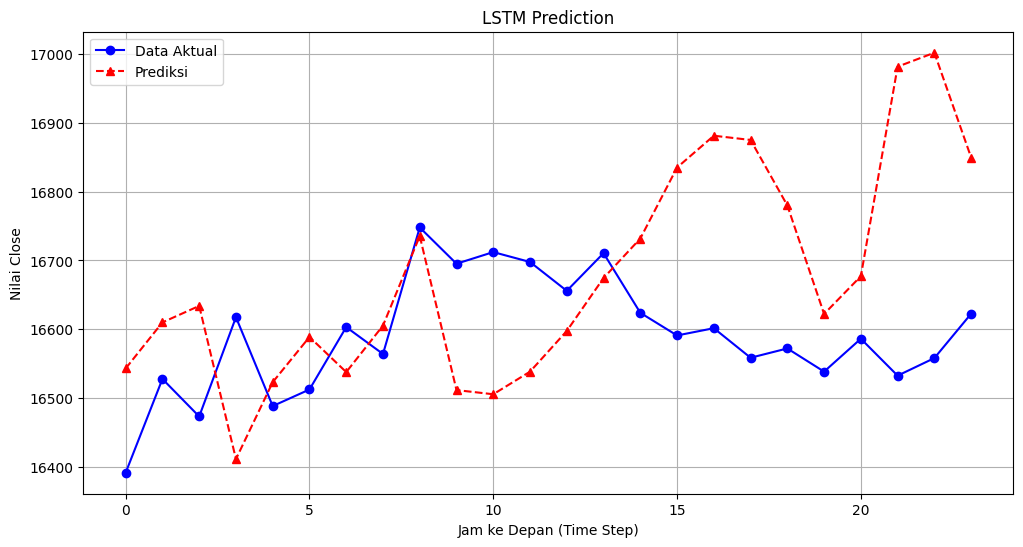

In [35]:
plot_prediction(actual_lstm_original, predicted_lstm_original, "LSTM Prediction")

In [36]:
lstm_df = build_comparison_table(actual_lstm_original, predicted_lstm_original)
lstm_df

,Jam ke,Data Aktual,Hasil Prediksi,Selisih
0,1,16391.62,16543.094795,151.474795
1,2,16527.81,16609.978780,82.168780
2,3,16473.32,16633.898874,160.578874
3,4,16617.47,16411.412346,206.057654
4,5,16488.41,16523.120414,34.710414
5,6,16512.51,16588.765572,76.255572
6,7,16603.11,16537.785396,65.324604
7,8,16564.07,16605.310255,41.240255
8,9,16747.83,16735.404664,12.425336
9,10,16695.18,16511.648094,183.531906


## Seq2Seq LSTM Model Inference

In [37]:
# Build encoder & decoder model for inference
encoder_model = build_encoder_model(seq2seq_model, INPUT_LENGTH, 1)
decoder_model = build_decoder_model(seq2seq_model, 64, 1)

# Ambil 1 batch dari test dataset
for (encoder_in, decoder_in), decoder_target in seq2seq_test_ds.take(1):
    sample_encoder_input = encoder_in[0:1]
    sample_decoder_target = decoder_target[0].numpy()
    break

# Lakukan autoregressive prediction
predicted_sequence_scaled = predict_seq2seq_autoreg(
    sample_encoder_input,
    encoder_model,
    decoder_model,
    OUTPUT_LENGTH,
    1
)

# Buat dummy array untuk kompatibel dengan scaler.inverse_transform
dummy_pred = np.zeros((len(predicted_sequence_scaled), num_features))
dummy_pred[:, 0] = predicted_sequence_scaled          # hanya fitur ke-0 yang diisi prediksi
predicted_sequence_original = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_target = np.zeros((len(sample_decoder_target), num_features))
dummy_target[:, 0] = sample_decoder_target[:, 0]       # target asli hanya pada feature 0
actual_sequence_original = scaler.inverse_transform(dummy_target)[:, 0]

# Print hasil akhir
print("Prediksi (skala asli):", predicted_sequence_original)
print("\nAktual   (skala asli):", actual_sequence_original)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Prediksi (skala asli): [42871.91457374 43871.73977736 44361.27744565 44624.1116962
 44774.93256139 44865.44693068 44921.32876519 44956.4061072
 44978.63086138 44992.77885272 45001.7842482  45007.51211673
 45011.13300364 45013.4038616  45014.84753419 45015.72154138
 45016.2521886  45016.57994129 45016.75162127 45016.86087217
 45016.91549762 45016.94671216 45016.9545158  45016.9545158 ]

Aktual   (skala asli): [16391.62 16527.81 16473.32 16617.47 16488.41 16512.51 16603.11 16564.07
 16747.83 16695.18 16712.07 16697.69 16655.8  16710.5  16623.9  16590.98
 16601.53 16558.61 16572.11 16538.45 16586.23 16532.59 16558.11 16622.53]


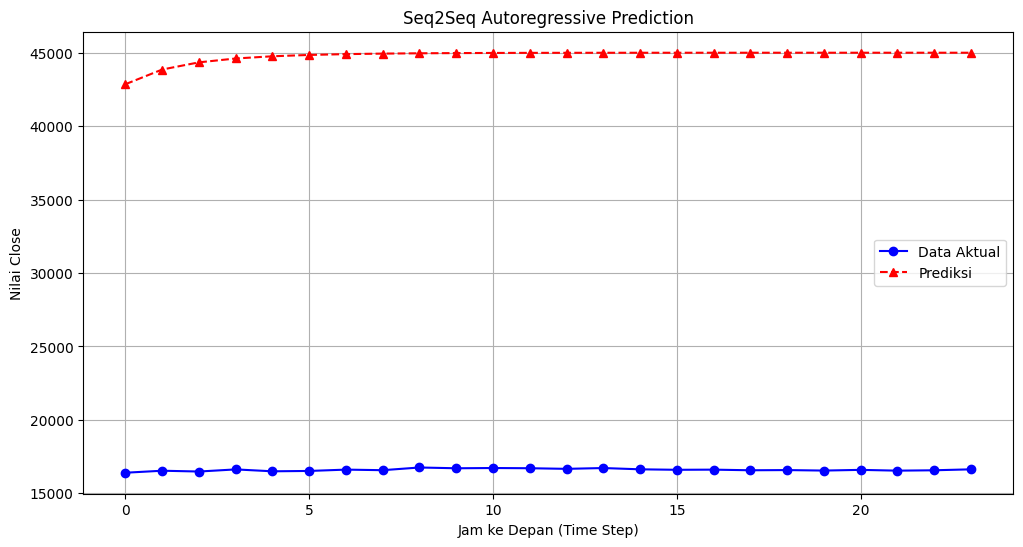

In [38]:
plot_prediction(actual_sequence_original, predicted_sequence_original, "Seq2Seq Autoregressive Prediction")

In [39]:
df_seq2seq = build_comparison_table(actual_sequence_original, predicted_sequence_original)
df_seq2seq

,Jam ke,Data Aktual,Hasil Prediksi,Selisih
0,1,16391.62,42871.914574,26480.294574
1,2,16527.81,43871.739777,27343.929777
2,3,16473.32,44361.277446,27887.957446
3,4,16617.47,44624.111696,28006.641696
4,5,16488.41,44774.932561,28286.522561
5,6,16512.51,44865.446931,28352.936931
6,7,16603.11,44921.328765,28318.218765
7,8,16564.07,44956.406107,28392.336107
8,9,16747.83,44978.630861,28230.800861
9,10,16695.18,44992.778853,28297.598853


# Saved Keras Model

In [40]:
# save baseline LSTM model
attention_lstm_model.save('model_baseline_LSTM.keras')

# save model seq2seq lstm model
seq2seq_model.save('model_seq2seq_LSTM.keras')